In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import nbimporter
import import_ipynb
import feature_extraction
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt
import csv
from datetime import datetime
random_state = 2053

In [24]:
def get_feat_names(df,drop):
    if drop==[]:
        return df.columns.values
    else:
        return df.drop(columns=drop).columns

In [25]:
def train_valid_test(df,mask,target_col,feat_names):

    X = df.drop(columns=[target_col]).values
    y = df[target_col].values
    
    X_train_valid = X[mask]
    y_train_valid = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    
    print("Shapes (train/valid, test): ",X_train_valid.shape, y_train_valid.shape, X_test.shape ,y_test.shape)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,y_train_valid, shuffle=True,train_size=0.8, random_state=random_state)
    print("Shapes train:", X_train.shape)
    
    return X_train, X_valid, y_train, y_valid, X_test, X_train_valid,y_train_valid

In [26]:
#regressor fit and predict
def regressor(X_train,y_train,X_valid,y_valid,reg):
    reg.fit(X_train, y_train)
    y_pred_train=reg.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    y_pred = reg.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    return reg, rmse,rmse_train

In [27]:
def scrivi_files(df_eval,nome,y_pred,params):
    
    now = datetime.now()

    with open(f"./predizioni/{nome}.csv", 'w',newline='') as pred_file:
        writer = csv.writer(pred_file)
        writer.writerow(['Id', 'Predicted'])
        list_indexes = df_eval.index
        for i, ind in enumerate(list_indexes):
            writer.writerow([df_eval.loc[ind,"Id"],y_pred[i]])
    
    with open(f"./predizioni/{nome}.txt","w") as file_txt:
        file_txt.write(f"Best params: {params}")
        file_txt.write(f"\n{now.strftime("%Y-%m-%d %H:%M:%S")}")
        

***START***

In [28]:
directory="./data_completi"

if not os.listdir(directory):
    df_dumm,df_mask,df_dev,df_eval= feature_extraction.main()
else:
    df_dev = pd.read_csv('./data_completi/dev.csv')
    df_eval = pd.read_csv('./data_completi/eval.csv')
    df_dumm=pd.read_csv('./data_completi/df_tot.csv')
    df_mask=np.reshape(pd.read_csv('./data_completi/mask.csv').values, newshape=df_dumm.shape[0])
    

In [29]:
display(df_dumm.head())

,age,mean_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,...,ethnicity_xasonga,ethnicity_xiang,ethnicity_yakut,ethnicity_yapese,ethnicity_yiddish,ethnicity_yoruba,ethnicity_yupik,ethnicity_zulu,gender_female,gender_male
0,24.0,1821.6906,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,...,False,False,False,False,False,False,False,False,True,False
1,22.0,1297.8187,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,...,False,False,False,False,False,False,False,False,True,False
2,22.0,1332.8524,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,...,False,False,False,False,False,False,False,False,True,False
3,22.0,1430.3499,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,...,False,False,False,False,False,False,False,False,True,False
4,22.0,1688.7234,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,...,False,False,False,False,False,False,False,False,False,True


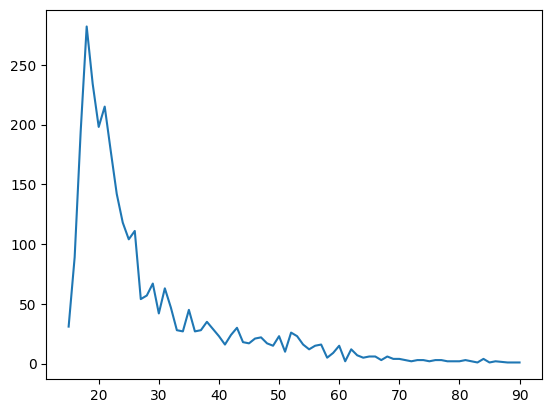

In [30]:
a=df_dev.groupby('age')['jitter'].count()
plt.plot(a)

In [31]:
#Drop ethnicity columns
df_dumm = df_dumm.drop(columns=[x for x in df_dumm.columns if "ethnicity" in x])


********************************************************************************************************************************************************
***RIDGE***

We divide each column by its norm divided by sqrt of m. We apply this standardization to valid and test subsets.

In [32]:
def get_norme(X):
    m=X.shape[0]
    n=X.shape[1]
    A=np.ndarray((m,n))
    norme=[]
    for j in range(n):
        t=np.linalg.norm(X[:,j].astype("float64"))/np.sqrt(m)
        norme.append(t)
        A[:,j]= X[:,j].astype("float64")/t
    
    return A,norme

In [33]:
def transform_ridge(X,norme):
    A=np.ndarray(X.shape)

    for j in range(X.shape[1]):
        A[:,j]= X[:,j]/norme[j]
    return A

In [34]:
def scale(X_train, X_valid, X_test):
    A_train,norme=get_norme(X_train)
    A_valid=transform_ridge(X_valid,norme)
    A_test=transform_ridge(X_test,norme)
    #A_tv =transform_ridge(X_tv,norme)

    return A_train,A_valid,A_test

In [35]:
def grid_ridge(params,A,y):
    #grid search ridge
    grid_search = GridSearchCV(Ridge(), params, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(A, y)

    print("\nResult grid search:")
    print("Migliori:", grid_search.best_params_)
    print("RMSE:", (-grid_search.best_score_)**0.5)
    return grid_search.best_params_, (-grid_search.best_score_)**0.5, grid_search


In [36]:
def master_ridge(X_train, y_train, X_valid, y_valid, X_test):
           
    #grid
    param_grid_search = {
        'alpha': [0.01,0.1, 0.5, 1 ,1.5, 3 , 5 ,7.5, 10, 20 , 50, 100]        
    }
    best_params, grid_score, grid_search=grid_ridge(param_grid_search,X_train,y_train)
    #display(pd.DataFrame(grid_search.cv_results_))

    # best_params = {
    # "alpha": 0.01,
    # "random_state":random_state
    # }
   # grid_score=-1

    y_pred_grid= grid_search.best_estimator_.predict(X_valid)
    rmse_grid = np.sqrt(mean_squared_error(y_valid, y_pred_grid))

    reg=Ridge(**best_params)
    
    reg_ridge,score,score_train=regressor(X_train,y_train,X_valid,y_valid,reg)
    
    print("\nResult regression validation:")
    print("Trained model: ",reg_ridge.get_params())
    print("Score valid: ",score)
    print("Score train: ",score_train)

    print("Score grid: ",rmse_grid)

    y_pred=reg_ridge.predict(X_test)
    
    return reg_ridge,y_pred,score, grid_score
    
    

**Ridge regressor without scaling**

In [37]:
X_train, X_valid, y_train, y_valid, X_test, _, _ = train_valid_test(df_dumm,df_mask,"age",[]) #split df

reg_ridge, y_pred,s, grid_score=master_ridge(X_train, y_train, X_valid, y_valid, X_test)

scrivi_files(df_eval,"ridge_non_scalato",y_pred, reg_ridge.get_params)

Shapes (train/valid, test):  (2913, 161) (2913,) (691, 161) (691,)
Shapes train: (2330, 161)

Result grid search:
Migliori: {'alpha': 100}
RMSE: 10.261171476598829

Result regression validation:
Trained model:  {'alpha': 100, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Score valid:  10.657378925372104
Score train:  9.781399834008328
Score grid:  10.657378925372104


**Ridge regressor with column norm scaler**

In [38]:
X_train, X_valid, y_train, y_valid, X_test, _, _ = train_valid_test(df_dumm,df_mask,"age",[]) #split df

A_train, A_valid, A_test= scale(X_train, X_valid, X_test) #scale norm columns

reg_ridge, y_pred,s, grid_score=master_ridge(A_train, y_train, A_valid, y_valid, A_test)

scrivi_files(df_eval,"ridge_scalatA",y_pred, reg_ridge.get_params)

Shapes (train/valid, test):  (2913, 161) (2913,) (691, 161) (691,)
Shapes train: (2330, 161)

Result grid search:
Migliori: {'alpha': 0.1}
RMSE: 10.266859826155544

Result regression validation:
Trained model:  {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Score valid:  10.695603389697263
Score train:  9.673035684328365
Score grid:  10.695603389697263


**Ridge regressor with standard scaler**

In [39]:
X_train, X_valid, y_train, y_valid, X_test, _, _ = train_valid_test(df_dumm,df_mask,"age",[]) #split df

std=StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_valid_std = std.transform(X_valid)
X_test_std = std.transform(X_test)

reg_ridge, y_pred,s, grid_score=master_ridge(X_train_std, y_train, X_valid_std, y_valid, X_test_std)

scrivi_files(df_eval,"ridge_std",y_pred, reg_ridge.get_params)

Shapes (train/valid, test):  (2913, 161) (2913,) (691, 161) (691,)
Shapes train: (2330, 161)

Result grid search:
Migliori: {'alpha': 5}
RMSE: 10.260906041630935

Result regression validation:
Trained model:  {'alpha': 5, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Score valid:  10.68069662194613
Score train:  9.687482305766915
Score grid:  10.68069662194613


***PCA***

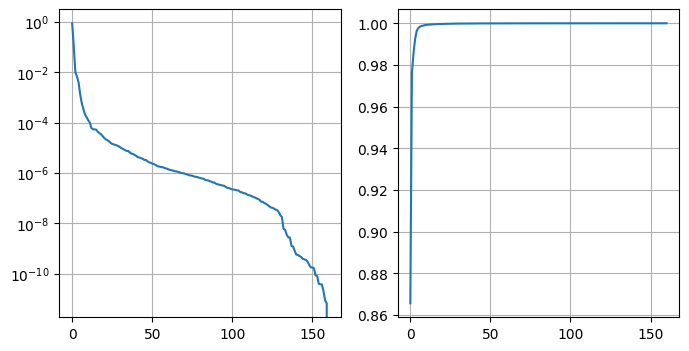

In [40]:

feat_names=get_feat_names(df_dumm,["age"])
ages=df_dumm.loc[:,"age"]
df_dumm=df_dumm.drop(columns=["age"])

pca=PCA(n_components=df_dumm.shape[1])
pca.fit(df_dumm)

var=pca.explained_variance_ratio_
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].semilogy(var)
cumsum= np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(cumsum)
ax[0].grid()
ax[1].grid()


In [41]:
def pca_trans(n,X_train,X_valid,X_test):
    pca = PCA(n_components=n)

    pca.fit(X_train)
    X_pca_train = pca.transform(X_train)
    X_pca_valid = pca.transform(X_valid)
    X_pca_test = pca.transform(X_test)

    return X_pca_train,X_pca_valid,X_pca_test, pca

**Ridge regressor with column norm scaler - PCA**

In [42]:
if "age" in df_dumm.columns:
    pass
else:
    df_dumm["age"]=ages

n_pca=150

print(f"\n********PCA {n_pca}**************")
X_train, X_valid, y_train, y_valid, X_test, _, _=train_valid_test(df_dumm,df_mask,"age",[]) #split df

A_train, A_valid, A_test= scale(X_train, X_valid, X_test) #scale norm columns
X_pca_train, X_pca_valid, X_pca_test, pca= pca_trans(n_pca, A_train,A_valid,A_test)


reg_ridge, y_pred, score, grid_score = master_ridge(X_pca_train, y_train, X_pca_valid, y_valid, X_pca_test)

scrivi_files(df_eval,f"pca{n_pca}_scalatA",y_pred, reg_ridge.get_params)






********PCA 150**************
Shapes (train/valid, test):  (2913, 161) (2913,) (691, 161) (691,)
Shapes train: (2330, 161)

Result grid search:
Migliori: {'alpha': 0.1}
RMSE: 10.287066819363817

Result regression validation:
Trained model:  {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Score valid:  10.704161425577162
Score train:  9.709075364283388
Score grid:  10.704161425577162


Text(0, 0.5, 'Weights')

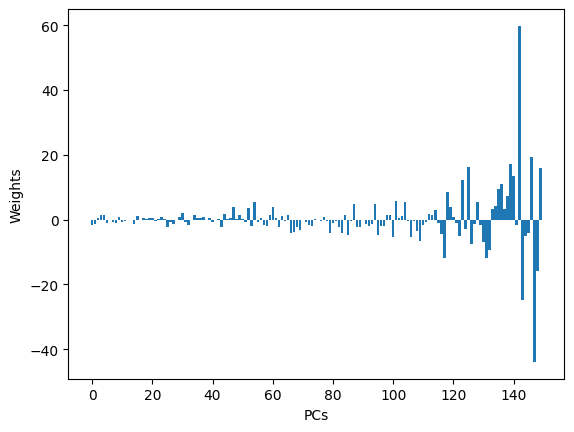

In [43]:
plt.bar(x=range(0,len(reg_ridge.coef_)),height=reg_ridge.coef_)
plt.xlabel('PCs')
plt.ylabel('Weights')

**Ridge regressor with standard scaler - PCA**

In [44]:
if "age" in df_dumm.columns:
    pass
else:
    df_dumm["age"]=ages

n_pca=150


X_train, X_valid, y_train, y_valid, X_test, _, _=train_valid_test(df_dumm,df_mask,"age",[])
print(f"\n********PCA {n_pca}**************")

std=StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_valid_std = std.transform(X_valid)
X_test_std = std.transform(X_test)

X_pca_train_std, X_pca_valid_std, X_pca_test_std, pca_std = pca_trans(n_pca, X_train_std, X_valid_std, X_test_std)

reg_ridge_std, y_pred, score, grid_score = master_ridge(X_pca_train_std, y_train, X_pca_valid_std, y_valid, X_pca_test_std)


scrivi_files(df_eval,f"pca{n_pca}_std",y_pred, reg_ridge.get_params)



Shapes (train/valid, test):  (2913, 161) (2913,) (691, 161) (691,)
Shapes train: (2330, 161)

********PCA 150**************

Result grid search:
Migliori: {'alpha': 5}
RMSE: 10.261108391981205

Result regression validation:
Trained model:  {'alpha': 5, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Score valid:  10.677051126604232
Score train:  9.705934335851499
Score grid:  10.677051126604232
